This notebook is for our first Classification model. We will start with a basic CNN model just to test that our structure is set up properly. This file may be adjusted and/or replaced before we turn in Milestone 3.

In [1]:
# Install libraries
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install scikit-image scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your depende

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

/Users/abenstirling/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# ./cvpr_depth/bathroom, bedroom, etc
import torch
from typing import List
from PIL import Image
from skimage.transform import resize_local_mean

home_image_folders_str = """bathroom
bedroom
children_room
corridor
dining_room
garage
kitchen
laundry
livingroom
nursery
pantry
"""
home_room_folders = home_image_folders_str.split('\n')

from pathlib import Path
import os
def enumerate_data_folder(folder: str) -> List[Path]:
    path = Path(f"../data/cvpr_raw/indoorCVPR_09/Images/{folder}")
    return list(path.glob("*"))

def get_all_data():
    out = []
    for folder in home_room_folders:
        print(f"Reading folder {folder}")
        for image_path in enumerate_data_folder(folder):
            if not os.path.isfile(image_path):
                continue

            img = np.asarray(Image.open(image_path).convert('RGB'))
            if img.dtype != np.uint8 and img.dtype != np.int8:
                print(f"got unrecognized image dtype {img.dtype}")
            img = img.astype(np.float32)
            # scale RGB values to [0, 1]
            img = img / 255.
            depth = torch.load(f"./cvpr_depth/{folder}/{image_path.name}.pt").cpu().numpy().squeeze()

            img = resize_local_mean(img, output_shape=(64, 64))
            depth = resize_local_mean(depth, output_shape=(64, 64))

            depth = depth.reshape((64, 64, 1))

            final = np.concatenate((img, depth), axis=-1)
            out.append((final, folder))
    return out


data = get_all_data()
data

Reading folder bathroom


FileNotFoundError: [Errno 2] No such file or directory: './cvpr_depth/bathroom/bath26.jpg.pt'

In [4]:
X = []
y = []
for arr, label in data:
    X.append(arr)
    y.append(label)

X = np.asarray(X)
y = np.asarray(y)
display(X)
display(y)
display(X.shape)
display(y.shape)

NameError: name 'data' is not defined

In [20]:
#from sklearn.preprocessing import OneHotEncoder

#encoder = OneHotEncoder(sparse_output=False)
#encoder.fit_transform(X=np.asarray(list(set(y))).reshape(-1, 1))
#y = encoder.transform(y.reshape(-1, 1))
#y.shape

In [5]:
# np.savez("./scaled_processed_data.npz", X=X, y=y)
data = np.load("scaled_processed_data.npz")
X = data["X"]
y = data["y"]

In [6]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=983) # X represents RGBD data, y represents labels

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(2922, 64, 64, 4)

(731, 64, 64, 4)

(2922, 10)

(731, 10)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# no more data augmentation

input_shape = (64, 64, 4)

# we can create an input tensor here 
inputs = Input(shape=input_shape)

# our custom CNN architecture, we got the batch normalization!!
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x) 
model = Model(inputs=inputs, outputs=output)

#compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# train the model using data generators
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)

Epoch 1/100
74/74 [==============================] - 12s 143ms/step - loss: 2.4850 - accuracy: 0.2823 - val_loss: 2.6624 - val_accuracy: 0.2329 - lr: 0.0010
Epoch 2/100
74/74 [==============================] - 10s 141ms/step - loss: 2.2717 - accuracy: 0.3516 - val_loss: 3.6573 - val_accuracy: 0.1849 - lr: 0.0010
Epoch 3/100
74/74 [==============================] - 11s 150ms/step - loss: 2.1750 - accuracy: 0.3777 - val_loss: 3.5864 - val_accuracy: 0.2038 - lr: 0.0010
Epoch 4/100
74/74 [==============================] - 10s 138ms/step - loss: 2.1050 - accuracy: 0.3802 - val_loss: 2.5957 - val_accuracy: 0.2945 - lr: 0.0010
Epoch 5/100
74/74 [==============================] - 10s 137ms/step - loss: 2.0489 - accuracy: 0.4059 - val_loss: 2.1058 - val_accuracy: 0.3801 - lr: 0.0010
Epoch 6/100
74/74 [==============================] - 10s 139ms/step - loss: 1.9904 - accuracy: 0.4102 - val_loss: 2.8043 - val_accuracy: 0.2226 - lr: 0.0010
Epoch 7/100
74/74 [==============================] - 10s 1

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


23/23 [==============================] - 1s 40ms/step - loss: 1.2605 - accuracy: 0.6416
Test Loss: 1.2604854106903076
Test Accuracy: 0.6415868401527405


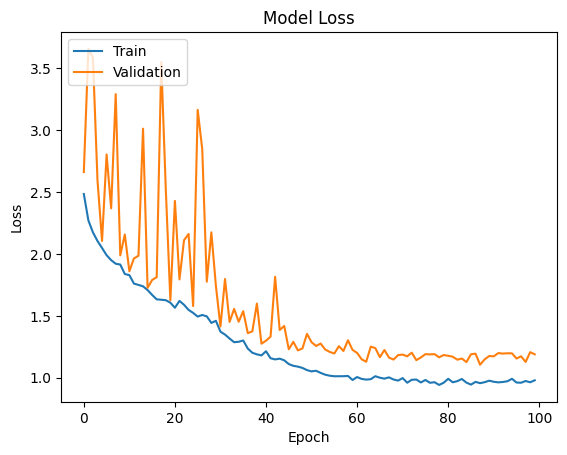

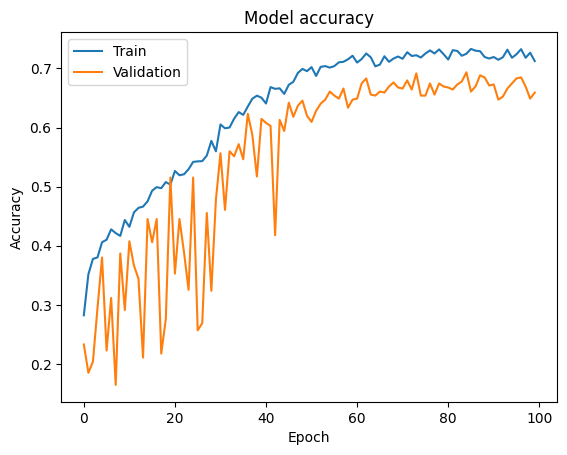

In [22]:
def plot_loss_metrics(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


plot_loss_metrics(history)